# Criação do modelo de Machine Learning

## Obtendo os dados

In [1]:
# Imports necessário para o sqlalchemy nessa aplicação
import pandas as pd
from sqlalchemy.sql import text
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from decouple import Config, RepositoryEnv

config = Config(RepositoryEnv(".env"))

In [2]:
# Criação da engine e da sessão para acessar o banco de dados
engine = create_engine(f"postgresql://{config('USER')}:{config('PASSWORD')}@{config('HOST')}:{config('PORT')}/tech")

In [3]:
# Criando a sessão
Sessao = sessionmaker(bind = engine)
sessao = Sessao()

In [4]:
# Lendo a tabela com o sqlalchemy
sql = """ SELECT * FROM ptr.petro 
          ORDER BY petro.dt DESC"""

query = sessao.execute(text(sql))

resultado_query = query.all()

sessao.close()

In [5]:
# Transformando a query em dataframe
df_query = pd.DataFrame(resultado_query, columns=['dt','preco'])
df_query

,dt,preco
0,2024-02-12,"83,88"
1,2024-02-09,"83,58"
2,2024-02-08,"83,01"
3,2024-02-07,"81,18"
4,2024-02-06,"80,46"
...,...,...
11102,1987-05-26,"18,63"
11103,1987-05-25,"18,60"
11104,1987-05-22,"18,55"
11105,1987-05-21,"18,45"


In [6]:
# Verificando as informações do DataFrame
df_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11107 entries, 0 to 11106
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dt      11107 non-null  object
 1   preco   11107 non-null  object
dtypes: object(2)
memory usage: 173.7+ KB


In [7]:
# Convertendo coluna 'dt' para datetime
df_query['dt'] = pd.to_datetime(df_query['dt'], format='%Y-%m-%d')
df_query

,dt,preco
0,2024-02-12,"83,88"
1,2024-02-09,"83,58"
2,2024-02-08,"83,01"
3,2024-02-07,"81,18"
4,2024-02-06,"80,46"
...,...,...
11102,1987-05-26,"18,63"
11103,1987-05-25,"18,60"
11104,1987-05-22,"18,55"
11105,1987-05-21,"18,45"


In [8]:
# Convertendo valores da coluna 'preco' para tipo float
df_query['preco'] = df_query['preco'].str.replace(',', '.').astype(float)
df_query

,dt,preco
0,2024-02-12,83.88
1,2024-02-09,83.58
2,2024-02-08,83.01
3,2024-02-07,81.18
4,2024-02-06,80.46
...,...,...
11102,1987-05-26,18.63
11103,1987-05-25,18.60
11104,1987-05-22,18.55
11105,1987-05-21,18.45


In [9]:
# verificando o shape do DataFrame
df_query.shape

(11107, 2)

In [10]:
# Verificando estatísticas da coluna preco
df_query['preco'].describe()

count    11107.000000
mean        52.836209
std         33.225370
min          9.100000
25%         20.440000
50%         47.950000
75%         75.855000
max        143.950000
Name: preco, dtype: float64

## Criando o modelo com XGBRegressor

In [11]:
# Importando libs de ML
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Criando uma cópia do DataFrame principal
df_modelo = df_query.copy()
df_modelo = df_modelo.sort_values(by='dt', ascending=True)

# Criando as colunas de atraso (lag features)
for lag in range(1, 4):
    df_modelo[f'preco_lag_{lag}'] = df_modelo['preco'].shift(lag)

# Removendo valores nulos
df_modelo = df_modelo.dropna()

# Atribuindo os dados de treinamento
X = df_modelo[['preco_lag_1','preco_lag_2','preco_lag_3']].values
y = df_modelo['preco'].values

# Criando uma seed de randomização
SEED = 123

# Separando os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=SEED)

# Selecionando os melhores parâmetros
param_grid = {

    'n_estimators': [25, 50, 100],

    'eta': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]

}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=3)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Criando e treinando o modelo de XGBC
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

# Fazendo previsões
previsoes = model.predict(X_test)

# Avaliando modelo
mse = mean_squared_error(y_test, previsoes)
mae = mean_absolute_error(y_test, previsoes)

# Imprimindo os valores de erro
print("Erro quadrático médio: ", mse)
print("Erro médio absoluto: ", mae)

Erro quadrático médio:  3.2198613021326894
Erro médio absoluto:  1.231824800043909


In [12]:
# Parâmetros selecionados
best_params

{'eta': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}

In [13]:
# Acurácia do modelo
accuracy = float(format(model.score(X_test, y_test)*100, '.2f'))
accuracy

99.13

## Finalização

In [14]:
# Salvando o dataframe do modelo
df_modelo.to_csv('DataFrame\df_modelo.csv')

In [15]:
# Gráfico em plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_modelo['dt'].iloc[-len(y_test):], y=y_test, mode='lines', name='Original'))
fig.add_trace(go.Scatter(x=df_modelo['dt'].iloc[-len(y_test):], y=previsoes, mode='lines', name='Previsão'))

fig.update_layout(title='Preços Originais vs Previsões (XGBC)',
                   xaxis_title='Data',
                   yaxis_title='Preço')
fig.show()

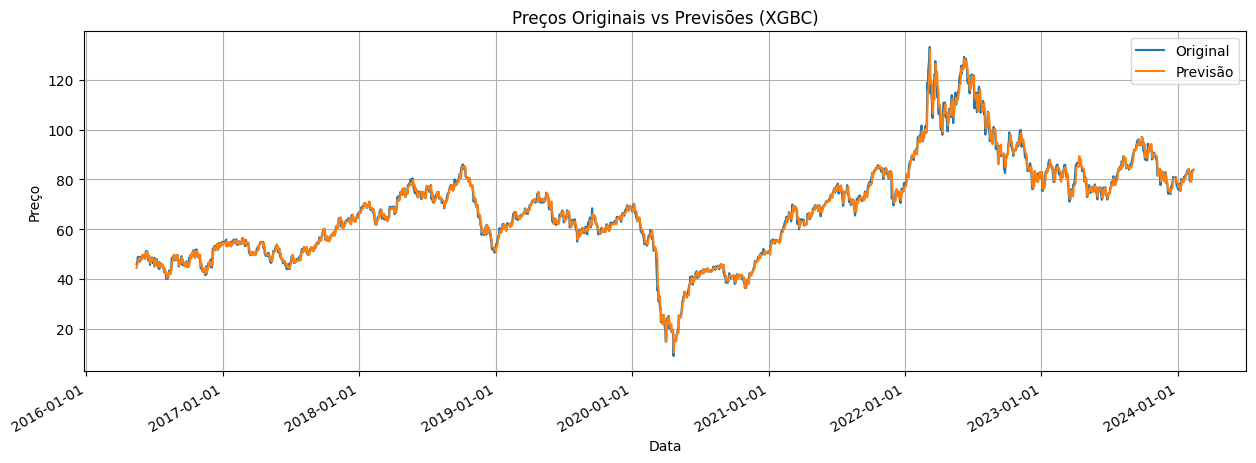

In [16]:
# Plotando resultados
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(15,5))
plt.plot(df_modelo['dt'].iloc[-len(y_test):], y_test, label='Original')
plt.plot(df_modelo['dt'].iloc[-len(previsoes):], previsoes, label='Previsão')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()

plt.legend()
plt.xlabel('Data')
plt.ylabel('Preço')
plt.grid(True)
plt.title('Preços Originais vs Previsões (XGBC)')
plt.savefig('Gráficos\original_vs_previsao.png')
plt.show()

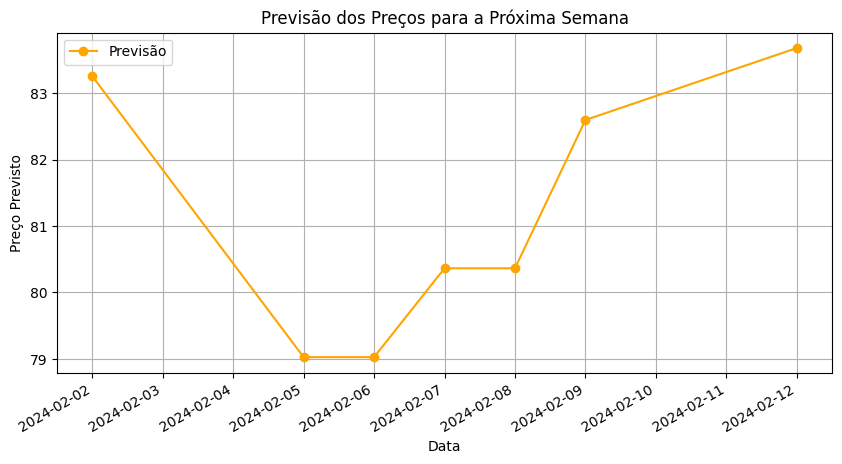

In [17]:
# Prevendo a próxima semana
previsoes_proxima_semana = previsoes[-7:]
df_modelo_proxima_semana = df_modelo['dt'].iloc[-len(y_test):][-7:]

plt.figure(figsize=(10,5))
plt.plot(df_modelo_proxima_semana[::-1], previsoes_proxima_semana[::-1], label='Previsão', color='orange', marker='o')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()

plt.title('Previsão dos Preços para a Próxima Semana')
plt.xlabel('Data')
plt.ylabel('Preço Previsto')
plt.legend()
plt.grid(True)
plt.savefig('Gráficos\proxima_semana.png')
plt.show()

In [18]:
# Salvando o modelo
model.save_model("Modelos\modelo_xgb.json")